In [7]:
import math
import numpy as np
import random
from graphviz import Digraph

In [3]:
# Understanding derivatives
a = 2.0
b = -3.0
c = 10.0

h = 0.001
d1 = a*b + c
a += h
d2 = a*b + c
slope = (d2-d1)/h
print(slope)
a*b + c

-3.0000000000001137


3.997

In [3]:
# Class Value with operator overloading
class Value:
    def __init__(self, value, _previous=(), _operation="", label="", gradient=0):
        self.value = value
        self._previous = set(_previous)
        self._operation = _operation
        self._backward = lambda: None
        self.gradient = gradient
        self.label = label
    def __repr__(self):
        return f"Value({self.value})"
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.value + other.value, (self, other), "+")
        def _backward():
            # (local) * (accumulated from chain rule)
            self.gradient += (1) * output.gradient
            other.gradient += (1) * output.gradient
        output._backward = _backward
        return output
    def __radd__(self, other):
        return self + other
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int and float"
        output = Value(self.value**other, (self,), f"**{other}")
        def _backward():
            self.gradient = (other * (self.value**(other-1) * output.gradient))
        output._backward = _backward
        return output
        return Value(self.value**other, (self,), f"**{other}")
    def __neg__(self): # -self
        return self * -1;
    def __sub__(self, other): # self - other
        return self + (-other)
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.value * other.value, (self, other), "*")
        def _backward():
            # (local) * (accumulated from chain rule)
            self.gradient += (other.value) * output.gradient
            other.gradient += (self.value) * output.gradient
        output._backward = _backward
        return output
    def __rmul__(self, other):
        return self * other
    def tanh(self):
        t = (math.exp(2*self.value) - 1)/(math.exp(2*self.value) + 1)
        output = Value(t, (self, ), 'tanh')
        def _backward():
            self.gradient = (1 - t**2) * output.gradient
        output._backward = _backward
        return output
    def exp(self):
        output = Value(math.exp(self.value), (self, ), "exp")
        def _backward():
            # (local) * (accumulated from chain rule)
            self.gradient += (output.value) * output.gradient
        output._backward = _backward
        return output
    def __truediv__(self, other): # self/other
        return self * other**-1
    def backward(self):
        # Calculate gradient by looping through node in a topological sorted graph
        sorted_nodes, visited = [], set()
        def topo_dfs(node):
            if node not in visited:
                visited.add(node)
                for child in node._previous:
                    topo_dfs(child)
                sorted_nodes.append(node)
        
        topo_dfs(self)
        # Traverse through stacked / visited dfs traversal
        self.gradient = 1.0 # base case
        for node in reversed(sorted_nodes):
            node._backward()

In [5]:
a = Value(4.0)
b = Value(1.0)
a-b

Value(3.0)

In [6]:
# Building the expression 
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
d = a*b
d.label = "d"
e = d + c
e.label = "e"
f = Value(-2.0, label="f")
L = e*f; L.label = "L"

# Calculate manually the gradient at each node compared to L (the loss function)
h = 0.0001
L.gradient = 1.0  # ((L.value + h) - L.value)/h 
f.gradient = 4.0  # L=d*f, dL/df=e, e=4.0 ∴ dL/df = 4.0
e.gradient = -2.0 # L=d*f, dL/de=f, f=-2.0 ∴ dL/de = -2.0
c.gradient = -2.0 # dL/dc = dL/de * de/dc (chain rule), de/dc = 1.0, ∴ dL/dc = -2.0 * 1.0 = 2.0
d.gradient = -2.0 # dL/dd = dL/de * de/dc (chain rule), de/dc = 1.0, ∴ dL/dc = -2.0 * 1.0 = 2.0
b.gradient = -4.0 # dL/db = dL/de * de/dc * dc/db = -2.0 * 1.0 * 2.0 = -4.0 ∴ dL/db = 4.0
a.gradient = 6.0  # dL/da = dL/de * de/dc * dc/da = -2.0 * 1.0 * -3.0 = 6.0 ∴ dL/db = 6.0

# Add "h" to the respective node and see how it calculates the resulting gradient
def calculateLGradient():
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b
    e.label = "d"
    d = e + c
    d.label = "e"
    f = Value(-2.0, label="f")
    L1 = d*f; L1.label = "L1"
    
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b
    e.label = "d"
    d = e + c
    d.label = "e"
    f = Value(-2.0, label="f")
    L2 = d*f; L2.label = "L2"

    print((L2.value-L1.value)/h)
    
# calculateLGradient()

In [76]:
# Nudge the leaf ndoes and see how it affects the loss function
nudge = 0.01
a.value += a.gradient * nudge
b.value += b.gradient * nudge
c.value += c.gradient * nudge
f.value += f.gradient * nudge

d = a * b
e = d + c
L = f * e

print(L)

Value(-7.286496)


In [33]:
# Visualize above graph
# Copied code from https://github.com/karpathy/micrograd/blob/master/trace_graph.ipynb
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._previous:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | value %.4f | grad %.4f }" % (n.label, n.value, n.gradient), shape='record')
        if n._operation:
            dot.node(name=str(id(n)) + n._operation, label=n._operation)
            dot.edge(str(id(n)) + n._operation, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._operation)
    
    return dot

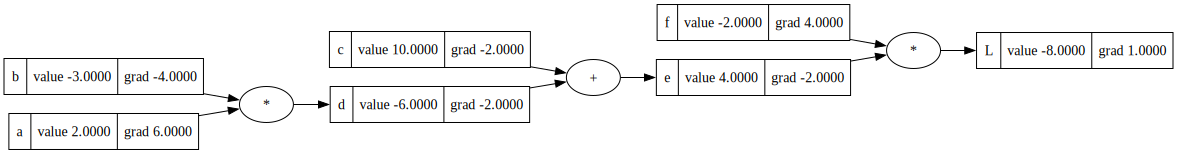

In [11]:
draw_dot(L)

In [7]:
# Calculate a more complex expression that mimics a neural network

# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# sum of all the weights
x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label ="x1w1x2w2"

n = x1w1x2w2 + b; n.label = "x1w1x2w2 + b"
# ----
e = (2*n).exp()
o = (e - 1)/(e + 1)
# ---- 
# o = n.tanh(); o.label = "o"

In [164]:
# Calculate gradient manually
o.gradient = 1.0  # base case
n.gradient = 0.5  # do/dn = 1 - tanh(o)**2 = 1 - 0.707**2 = 0.5
b.gradient = 0.5
x1w1x2w2.gradient = 0.5
x1w1.gradient = 0.5
x2w2.gradient = 0.5
w2.gradient = 0
x2.gradient = 0.5
w1.gradient = 1.0
x1.gradient = -1.5

In [172]:
# Calulate gradient by using backward propegation
o.gradient = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [181]:
# Calculate gradient by looping through node in a topological sorted graph
sorted_nodes, visited = [], set()
def topo_dfs(node):
    if node not in visited:
        visited.add(node)
        for child in node._previous:
            topo_dfs(child)
        sorted_nodes.append(node)

topo_dfs(o)
# Traverse through stacked / visited dfs traversal
o.gradient = 1.0 # base case
for node in reversed(sorted_nodes):
    node._backward()

In [8]:
# Calculate gradient with Value class function "backward"
o.backward()

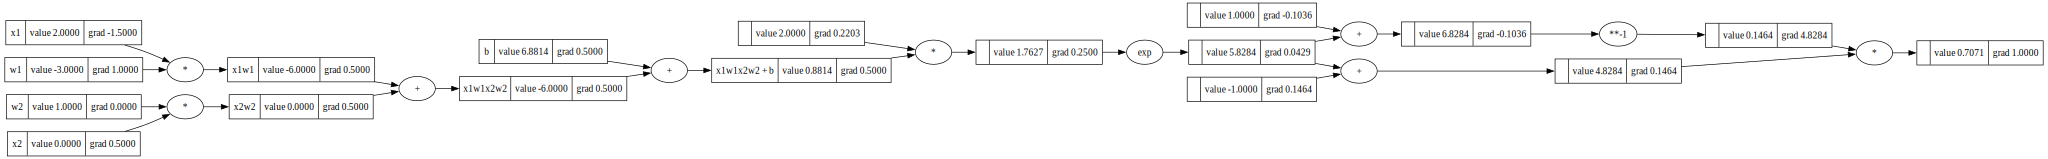

In [12]:
draw_dot(o)

In [20]:
# Create the same neural network but with PyTorch
import torch
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [5]:
class Neuron:
    def __init__(self, min):
        self.weight = [Value(random.uniform(-1,1)) for _ in range(min)]
        self.bias = Value(random.uniform(-1,1))
    def __call__(self, x):
        activation = sum((wi*xi for wi, xi in zip(self.weight, x)), self.bias)
        output = activation.tanh()
        return output
    def parameters(self):
        return self.weight + [self.bias]
class Layer:
    def __init__(self, min, nout):
        self.neurons = [Neuron(min) for _ in range(nout)]
    def __call__(self, x):
        outputs = [n(x) for n in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]        

class MultiLayerPerceptron:
    def __init__(self, min, nouts):
        sz = [min] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [10]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, -0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [8]:
n = MultiLayerPerceptron(3, [4,4,1])

In [31]:
ypred = [n(x) for x in xs]
ypred

[Value(0.9944489566280815),
 Value(-0.9964260029208525),
 Value(-0.9965908390069008),
 Value(0.9964834961680009)]

In [29]:
# wow it works that's so cool HEHHEHE
for k in range(100):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])

    # backward pass
    for p in n.parameters():
        p.gradient = 0
    loss.backward()

    # update
    for p in n.parameters():
        p.value += -0.2 * p.gradient

print(loss.value)
    

6.762209221351835e-05


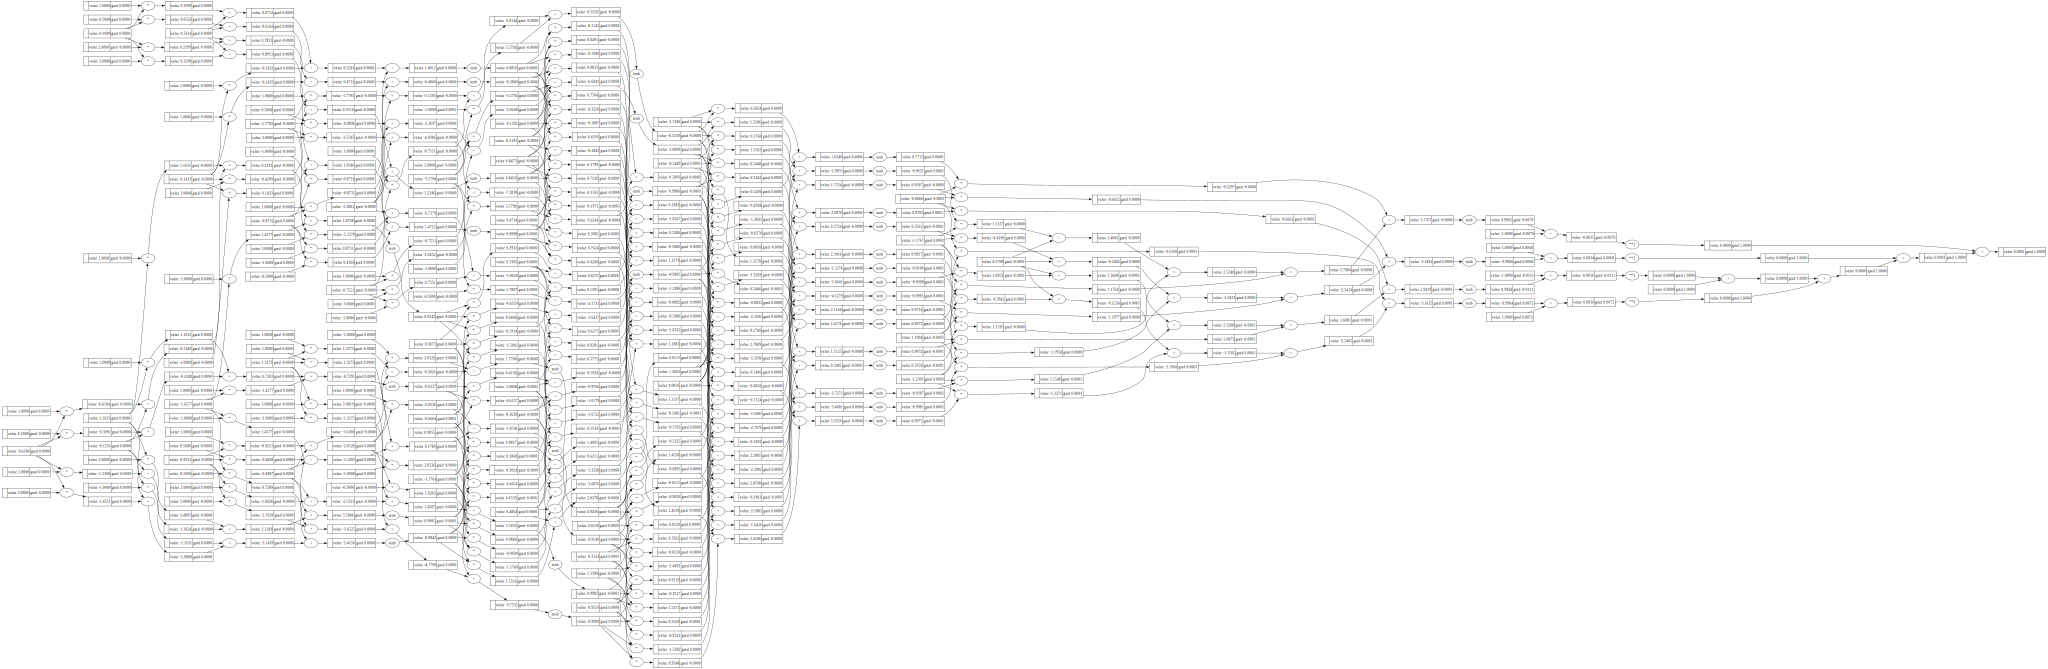

In [35]:
draw_dot(loss)